# Ordenando un patio de maniobras 

## Descripción

¡Felicidades! Eres el nuevo gerente de una patio de maniobras muy soleada, ideal para la eficiencia energética de tus equipos. Te han asignado cinco robots innovadores para ayudarte a organizar el espacio. El patio está en completo desorden debido al gerente anterior, así que tu tarea es coordinar a los robots para organizar las cajas y hacer que el patio de labores funcione de manera eficiente.

Cada robot tiene ruedas omnidireccionales, lo que les permite moverse en las cuatro direcciones. Además, pueden recoger cajas en celdas adyacentes y transportarlas a cualquier otra ubicación, incluso apilándolas en torres de hasta cinco cajas. Los robots están equipados con sensores avanzados que les permiten detectar lo que hay en las cuatro celdas alrededor de ellos: puede ser una celda vacía, una pared, una pila de cajas (y cuántas cajas contiene) o incluso otro robot. También saben cuándo están llevando una caja gracias a sus sensores de presión.

Cada robot consume una unidad de energía por cada celda que se desplaza. Inicialmente, cada robot dispone de 200 unidades de energía, permitiéndoles moverse una cantidad razonable antes de requerir recarga. Además, los robots están equipados con celdas fotovoltaicas para aprovechar la abundante luz solar en este espacio abierto. Cuando un robot necesita recargarse, debe permanecer inactivo durante 10 pasos de simulación para completar el proceso de recarga.

Tu misión es desarrollar una estrategia para organizar todas las cajas en pilas de exactamente cinco unidades cada una. Debes minimizar la distancia total recorrida por los robots, reducir el tiempo total de recarga y disminuir la cantidad de recargas necesarias para cada robot.

## Requerimientos

- El patio de maniobras tiene un tamaño de 20 x 20 celdas.
- Comienza con 100 cajas distribuidas aleatoriamente en el suelo del patio, sin pilas.
- Los robots empiezan en posiciones vacías y aleatorias.
- La simulación termina cuando todas las cajas están apiladas en columnas de cinco cajas.
- Desarrolla dos soluciones distintas: la primera sin coordinación, basada en movimientos aleatorios de los robots, y la segunda con una estrategia coordinada. La estrategia coordinada debe buscar minimizar la distancia total recorrida por los robots, reducir el tiempo total de recarga y disminuir la cantidad de recargas necesarias para cada robot.
- Debes crear una visualización tanto para la solución sin coordinación como para la solución con la estrategia coordinada.

## Especificaciones de entrega

- Deberás presentar un informe en formato PDF que describa detalladamente los mecanismos de coordinación utilizados, las estructuras de datos y los algoritmos empleados, junto con la justificación para cada elección. Además, utilizando gráficas y datos obtenidos de tus simulaciones, argumenta si la solución coordinada ha conseguido una mejora significativa. Si no es así, indica posibles cambios que podrías implementar para lograr esa mejora. Ten en cuenta que el informe debe tener una extensión mínima de una página y que los resultados basados en menos de 10 simulaciones no se considerarán fiables.

- El cuaderno Jupyter que contiene tu implementación en Python.



# Instalación e importación de librerías

In [220]:
# Descargar mesa y seaborn
%pip install mesa==2.3.1 seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [221]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con 'RandomActivation' podemos activar los agentes en un orden aleatorio.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete seaborn para mejorar la visualización de los datos.
import seaborn as sns

# Solución estratégica

El enfoque de esta solución consiste en las siguientes reglas.

- Los robots se mueven aleatoriamente para buscar paquetes.
- Los robots al iniciar su primera pila, guardan su ubicación y la comparten.
- Cuando un robot encuentra un paquete, lo lleva a la pila más cercana.
- Los robots compartirán un registro de las celdas visitadas para no buscar dónde ya se sabe que no hay paquetes

In [222]:
# Helpers

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 10
    return grid


In [223]:
class RobotAgent(Agent):
    """
    Clase que define al agente robot que ordenará los paquetes.
    """

    def __init__(self, id, model, max_energy, max_stacks):
        """
        Inicializa el agente robot.

        Args:
            id: Identificador único del agente.
            model: Modelo en el que se encuentra el agente.
            max_energy: Energía máxima del agente.
            max_stacks: Número máximo de pilas que puede ordenar el agente.
        """

        # Inicializa la clase padre.
        super().__init__(id, model)

        # ID
        self.id = id

        # Inicializa los atributos del agente (False = No está cargando, True = Está cargando).
        self.package = False

        # Energía
        self.energy = max_energy
        self.recharge = 0
        self.steps_to_recharge = 10

        # Inicializa el número de pilas que puede ordenar el agente.
        self.max_stacks = max_stacks

        # Backtracking
        self.path = []

    def get_most_valuable(self, possible_steps):
        """
        Obtiene la celda adyacente con el mayor valor.
        
        Si el robot tiene un paquete, busca una pila adyacente.

        Si el robot no tiene un paquete, busca un paquete adyacente.

        Args:
            possible_steps: Celdas adyacentes al agente.
        """

        max_step = None
        empty_cells = []

        for x, y in possible_steps:

            # ¿La celda adyacente está vacía?
            if self.model.cells[x][y] == 0:
                empty_cells.append((x, y))

            # ¿El agente tiene un paquete?
            if self.package:
                # ¿Hay una pila en la celda adyacente?
                if self.model.cells[x][y] > 1:
                    max_step = (x, y)
                    return max_step
                # ¿Hay un paquete en la celda adyacente?
                elif self.model.cells[x][y] == 1:
                    max_step = (x, y)
                    return max_step
            
            # ¿El agente no tiene un paquete?
            else:
                # ¿Hay un paquete en la celda adyacente?
                if self.model.cells[x][y] == 1:
                    max_step = (x, y)
                    return max_step

        # Si no se encontró una celda adyacente con un paquete o pila, se regresa una celda vacía.
        if not max_step and empty_cells:
            max_step = empty_cells[np.random.randint(0, len(empty_cells))]

        return max_step
    
    def get_distance(self, x1, y1, x2, y2):
        """
        Calcula la distancia entre dos celdas.
        """

        return abs(x1 - x2) + abs(y1 - y2)
    
    def reset_visited(self):
        """
        Reinicia la matriz de celdas visitadas.
        """

        # Reinicia la matriz de celdas visitadas.
        self.model.visited = np.zeros((self.model.width, self.model.height))

    def explore(self):
        """
        Mueve al agente robot a una celda adyacente aleatoria.
        """

        # Obtiene las celdas adyacentes.
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Busca un paquete en las celdas adyacentes.
        for i in indexes:
            # Obtiene las coordenadas de la celda.
            (x, y) = possible_steps[i]

            # ¿No hay otro agente en la celda, no hay una pila y no ha visitado la celda?
            if self.model.grid.is_cell_empty((x, y)) and self.model.cells[x][y] == 0 and self.model.visited[x][y] == 0:
                
                # Guarda la celda anterior.
                self.path.append(self.pos)

                # Marca la celda como visitada.
                self.model.visited[x][y] = 1

                # Mueve al agente a la celda.
                self.model.grid.move_agent(self, (x, y))
                self.energy -= 1

                return True
        
        # Si no se encontró una celda adyacente libre, se regresa a la celda anterior
        if self.path:
            (x, y) = self.path[-1]
            # Comprueba si la celda anterior está vacía
            if self.model.grid.is_cell_empty((x, y)):
                # Mueve al agente a la celda.
                self.model.grid.move_agent(self, (x, y))
                self.path.pop()
                self.energy -= 1
                return True
            
        return False

        
    def move_to_closest_stack(self):
        """
        Mueve al agente robot a la pila más cercana.
        """

        if not self.model.stacks:
            return

        # Obtiene las coordenadas del agente.
        (x, y) = self.pos

        # Obtener pila más cercana
        closest = None
        for stack in self.model.stacks:
            if closest is None:
                closest = stack
            else:
                x1, y1 = closest
                x2, y2 = stack
                if self.get_distance(x, y, x1, y1) > self.get_distance(x, y, x2, y2):
                    closest = stack

        # Encuentra el camino más corto a la pila más cercana.
        dx = abs(closest[0] - x)
        dy = abs(closest[1] - y)

        # Mueve al agente a la pila más cercana.
        if dx > dy:
            next_x = x + (1 if closest[0] > x else -1)
            next_y = y
        else:
            next_x = x
            next_y = y + (1 if closest[1] > y else -1)

        # Mueve al agente a la celda si el siguiente paso es válido.
        if 0 <= next_x < self.model.width and 0 <= next_y < self.model.height:
            if self.model.grid.is_cell_empty((next_x, next_y)) and (next_x, next_y) != (closest[0], closest[1]):

                # Guarda la posición anterior.
                self.path.append(self.pos)

                # Mueve al agente a la celda.
                self.model.grid.move_agent(self, (next_x, next_y))
                self.model.visited[next_x][next_y] = 1

                self.energy -= 1
    
    def step(self):
        """
        Paso de simulación del agente robot.
        """

        # ¿El agente está recargando energía?
        if self.energy <= 0:
            # ¿Ya terminó de recargar energía?
            if self.recharge == self.steps_to_recharge:
                # Reinicia la energía del agente.
                self.energy = self.model.max_energy
                self.recharge = 0

            else:
                # Incrementa la recarga.
                self.recharge += 1

        
        # Obtiene las celdas adyacentes.
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False)
        
        # Obtiene la celda adyacente con el mayor valor.
        (x, y) = self.get_most_valuable(possible_steps)


        # Caso 1: El agente tiene un paquete.
        if self.package:

            # Caso 1.1: El agente tiene un paquete y hay una pila adyacente.
            # Deja el paquete en la pila adyacente y busca otro paquete.
            if self.model.cells[x][y] > 1 and self.model.cells[x][y] < self.model.stack_height:
                
                # Deja el paquete en la pila.
                self.model.cells[x][y] += 1
                self.package = False

                # ¿El stack está lleno?
                if self.model.cells[x][y] == self.model.stack_height:
                    # Elimina la pila de la lista de pilas.
                    self.model.stacks.remove((x, y))
                    self.model.stacks_completed += 1
            
            # Caso 1.2: El agente tiene un paquete y hay un paquete adyacente.
            # Deja el paquete en la pila adyacente y busca otro paquete.
            elif self.model.cells[x][y] == 1:
                # ¿Puede crear otro stack?
                if self.model.stacks_created < self.model.max_stacks:

                    # Deja el paquete en la pila.
                    self.model.cells[x][y] += 1
                    self.package = False

                    # Añade la pila a la lista de pilas.
                    self.model.stacks.append((x, y))
                    self.model.stacks_created += 1
                
                else:
                    if self.model.stacks:
                        self.move_to_closest_stack()
                    else:
                        if not self.explore():
                            self.reset_visited()
                            self.explore()

            # Caso 1.3: El agente tiene un paquete y no hay nada adyacente de interés.
            # Si hay pilas disponibles, busca una pila. Si no, se mueve a una celda adyacente aleatoria.
            else:
                if self.model.stacks:
                    self.move_to_closest_stack()
                else:
                    if not self.explore():
                        self.reset_visited()
                        self.explore()

        # Caso 2: El agente no tiene un paquete.
        else:

            # Caso 2.1: El agente no tiene un paquete y hay un paquete adyacente.
            # Recoge el paquete y busca una pila.
            if self.model.cells[x][y] == 1:
                # Recoge el paquete.
                self.model.cells[x][y] = 0
                self.package = True

            # Caso 2.2: El agente no tiene un paquete y no hay un paquete adyacente.
            # Si hay paquetes disponibles, busca uno. Si no, se mueve a una celda adyacente aleatoria.
            else:     
                if not self.explore():
                    self.reset_visited()
                    self.explore()

In [224]:
class RobotAgent(Agent):
    """
    Clase que define al agente robot que ordenará los paquetes.
    """

    def __init__(self, id, model, max_energy, max_stacks):

        # Inicializa la clase padre.
        super().__init__(id, model)

        # ID
        self.id = id

        # Inicializa los atributos del agente (False = No está cargando, True = Está cargando).
        self.package = False

        # Energía
        self.energy = max_energy
        self.recharge = 0
        self.steps_to_recharge = 10

        # Inicializa el número de pilas que puede ordenar el agente.
        self.max_stacks = max_stacks

        # Backtracking
        self.path = []

        # Evitar congestión
        self.target_stack = None  
        self.stack_attempt_counter = 0  
        self.max_stack_attempts = 5 

    def get_distance(self, x1, y1, x2, y2):
        """
        Calcula la distancia entre dos celdas.
        """

        return abs(x1 - x2) + abs(y1 - y2)
    
    def reset_visited(self):
        """
        Reinicia la matriz de celdas visitadas.
        """

        # Reinicia la matriz de celdas visitadas.
        self.model.visited = np.zeros((self.model.width, self.model.height))

    def get_most_valuable(self, possible_steps):
        """
        Obtiene la celda adyacente con el mayor valor, considerando congestión.
        """
        max_step = None
        empty_cells = []
        stack_cells = []

        for x, y in possible_steps:
            if self.model.cells[x][y] == 0:
                empty_cells.append((x, y))
            
            if self.package:
                # Si tenemos una pila objetivo, priorizarla
                if self.target_stack and (x, y) == self.target_stack:
                    if self.model.cells[x][y] < self.model.stack_height:
                        return (x, y)
                
                # Recolectar todas las pilas disponibles para evaluación
                if self.model.cells[x][y] > 1 and self.model.cells[x][y] < self.model.stack_height:
                    stack_cells.append((x, y))
                elif self.model.cells[x][y] == 1 and self.model.stacks_created < self.model.max_stacks:
                    max_step = (x, y)
                    return max_step
            else:
                if self.model.cells[x][y] == 1:
                    max_step = (x, y)
                    return max_step

        # Evaluar pilas considerando congestión
        if stack_cells:
            least_congested = None
            min_agents_nearby = float('inf')
            
            for stack in stack_cells:
                agents_nearby = self.count_agents_near_stack(stack)
                if agents_nearby < min_agents_nearby:
                    min_agents_nearby = agents_nearby
                    least_congested = stack
            
            if least_congested:
                return least_congested

        if not max_step and empty_cells:
            max_step = empty_cells[np.random.randint(0, len(empty_cells))]

        return max_step

    def count_agents_near_stack(self, stack_pos):
        """
        Cuenta el número de agentes cerca de una pila específica.
        """
        x, y = stack_pos
        nearby_cells = [(x+i, y+j) for i in [-1,0,1] for j in [-1,0,1]
                       if 0 <= x+i < self.model.width and 0 <= y+j < self.model.height]
        
        count = 0
        for cell in nearby_cells:
            cell_contents = self.model.grid.get_cell_list_contents(cell)
            count += sum(1 for agent in cell_contents if isinstance(agent, RobotAgent))
        return count

    def move_to_closest_stack(self):
        """
        Mueve al agente robot a la pila más cercana, considerando congestión.
        """
        if not self.model.stacks:
            return False

        x, y = self.pos
        
        # Si ya tenemos una pila objetivo y hemos excedido los intentos, buscar una nueva
        if self.target_stack:
            self.stack_attempt_counter += 1
            if self.stack_attempt_counter >= self.max_stack_attempts:
                self.target_stack = None
                self.stack_attempt_counter = 0

        # Encontrar la pila menos congestionada entre las más cercanas
        if not self.target_stack:
            closest_stacks = sorted(self.model.stacks, 
                                  key=lambda s: self.get_distance(x, y, s[0], s[1]))[:3]
            
            min_congestion = float('inf')
            best_stack = None
            
            for stack in closest_stacks:
                congestion = self.count_agents_near_stack(stack)
                if congestion < min_congestion:
                    min_congestion = congestion
                    best_stack = stack
            
            self.target_stack = best_stack

        if not self.target_stack:
            return False

        # Moverse hacia la pila objetivo
        dx = abs(self.target_stack[0] - x)
        dy = abs(self.target_stack[1] - y)

        if dx > dy:
            next_x = x + (1 if self.target_stack[0] > x else -1)
            next_y = y
        else:
            next_x = x
            next_y = y + (1 if self.target_stack[1] > y else -1)

        if (0 <= next_x < self.model.width and 0 <= next_y < self.model.height and
            self.model.grid.is_cell_empty((next_x, next_y)) and 
            (next_x, next_y) != self.target_stack):
            
            self.path.append(self.pos)
            self.model.grid.move_agent(self, (next_x, next_y))
            self.model.visited[next_x][next_y] = 1
            self.energy -= 1
            return True

        return False
    
    def explore(self):
        """
        Mueve al agente robot a una celda adyacente aleatoria.
        """

        # Obtiene las celdas adyacentes.
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Busca un paquete en las celdas adyacentes.
        for i in indexes:
            # Obtiene las coordenadas de la celda.
            (x, y) = possible_steps[i]

            # ¿No hay otro agente en la celda, no hay una pila y no ha visitado la celda?
            if self.model.grid.is_cell_empty((x, y)) and self.model.cells[x][y] == 0 and self.model.visited[x][y] == 0:
                
                # Guarda la celda anterior.
                self.path.append(self.pos)

                # Marca la celda como visitada.
                self.model.visited[x][y] = 1

                # Mueve al agente a la celda.
                self.model.grid.move_agent(self, (x, y))
                self.energy -= 1

                return True
        
        # Si no se encontró una celda adyacente libre, se regresa a la celda anterior
        if self.path:
            (x, y) = self.path[-1]
            # Comprueba si la celda anterior está vacía
            if self.model.grid.is_cell_empty((x, y)):
                # Mueve al agente a la celda.
                self.model.grid.move_agent(self, (x, y))
                self.path.pop()
                self.energy -= 1
                return True
            
        return False

    def step(self):
        """
        Paso de simulación del agente robot con manejo mejorado de congestión.
        """
        if self.energy <= 0:
            if self.recharge == self.steps_to_recharge:
                self.energy = self.model.max_energy
                self.recharge = 0
            else:
                self.recharge += 1
            return

        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False)
        
        next_step = self.get_most_valuable(possible_steps)
        
        if not next_step:
            if not self.explore():
                self.reset_visited()
                self.explore()
            return

        x, y = next_step

        if self.package:
            if self.model.cells[x][y] > 1 and self.model.cells[x][y] < self.model.stack_height:
                self.model.cells[x][y] += 1
                self.package = False
                self.target_stack = None
                self.stack_attempt_counter = 0

                if self.model.cells[x][y] == self.model.stack_height:
                    self.model.stacks.remove((x, y))
                    self.model.stacks_completed += 1
                    
            elif self.model.cells[x][y] == 1 and self.model.stacks_created < self.model.max_stacks:
                self.model.cells[x][y] += 1
                self.package = False
                self.model.stacks.append((x, y))
                self.model.stacks_created += 1
                
            else:
                if self.model.stacks:
                    if not self.move_to_closest_stack():
                        if not self.explore():
                            self.reset_visited()
                            self.explore()
                else:
                    if not self.explore():
                        self.reset_visited()
                        self.explore()
        else:
            if self.model.cells[x][y] == 1:
                self.model.cells[x][y] = 0
                self.package = True
            else:
                if not self.explore():
                    self.reset_visited()
                    self.explore()

In [225]:
class YardModel(Model):
    """
    Clase que define el modelo de la simulación.
    """

    def __init__(self, width, height, n_agents, n_packages, stack_height, max_energy):
        """
        Inicializa el modelo de la simulación.

        Args:
            width: Ancho del entorno.
            height: Alto del entorno.
            n_agents: Número de agentes robots.
            n_packages: Número de paquetes.
            stack_height: Altura máxima de las pilas.
            max_energy: Energía máxima de los agentes robots.
        """

        # Inicializa la clase padre.
        super().__init__()

        # Inicializa el tamaño del entorno.
        self.width = width
        self.height = height

        # Altura máxima de las pilas.
        self.stack_height = stack_height

        # Máxima energía de los agentes.
        self.max_energy = max_energy

        # Máximo número de pilas que se pueden ordenar.
        self.max_stacks = n_packages // stack_height

        # Stacks creados e completados.
        self.stacks_created = 0
        self.stacks_completed = 0

        # Inicializa la cuadrícula.
        self.grid = SingleGrid(width, height, torus=False)

        # Inicializa el programa de activación.
        self.schedule = RandomActivation(self)

        # Inicializa la matriz de celdas.
        self.cells = np.zeros((width, height))
        self.visited = np.zeros((width, height))

        # Pasos que ha dado la simulación.
        self.steps = 0

        # Array de paquetes y stacks de paquetes
        self.stacks = []

        # Coloca los paquetes en la cuadrícula.
        i = 0
        while i < n_packages:
            # Posición aleatoria del paquete.
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            # ¿La celda está vacía?
            if self.cells[x][y] == 0:
                # Coloca el paquete en la celda.
                self.cells[x][y] = 1
                i += 1

        # Inicializa los agentes robots.
        i = 0
        while i < n_agents:
            # Posición aleatoria del agente.
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            # ¿La celda está vacía?
            if self.cells[x][y] == 0 and self.grid.is_cell_empty((x, y)):
                # Crea un agente robot.
                agent = RobotAgent(i, self, max_energy, self.max_stacks)

                # Coloca al agente en la celda.
                self.grid.move_agent(agent, (x, y))

                # Añade al agente al programa de activación.
                self.schedule.add(agent)
                i += 1

        # Inicializa el colector de datos.
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Stack Completed": lambda m: m.stacks_completed
            }
        )

    def game_over(self):
        """
        Verifica si el juego ha terminado.
        """

        # Verifica si el juego ha terminado.
        return self.stacks_completed == self.max_stacks or self.steps >= 1000
    
    def step(self):
        """
        Avanza un paso en la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

## Simulación

In [226]:
X, Y = 20, 20
N_AGENTS = 5
N_PACKAGES = 100
STACK_HEIGHT = 5
MAX_ENERGY = 100

# Inicializar el modelo
model = YardModel(X, Y, N_AGENTS, N_PACKAGES, STACK_HEIGHT, MAX_ENERGY)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Número de pilas completadas:", model.stacks_completed)

Modelo terminado en 556 pasos
Número de pilas completadas: 20


In [227]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

Grid  Stack Completed
0  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...                0
1  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...                0
2  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...                0
3  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...                0
4  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...                0

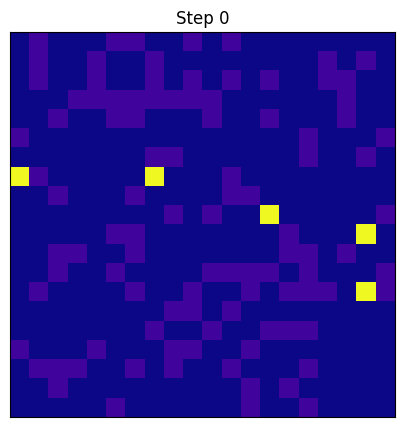

In [228]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

grids_data = [all_grids.iloc[i, 0] for i in range(len(all_grids))]

def animate(i):
    patch.set_data(grids_data[i])
    axs.set_title(f"Step {i}")
    return patch,


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False, blit=True)

In [229]:
anim

## Reflexión

El análisis de las gráficas y los resultados obtenidos con la estrategia coordinada muestra una mejora significativa en la eficiencia de los agentes en comparación con la estrategia aleatoria. Los agentes ahora necesitan en promedio menos pasos para llenar una pila, lo que indica que la coordinación y la comunicación entre ellos han reducido considerablemente el tiempo y la energía necesarios para completar la tarea.

La implementación de un sistema de comunicación y mapeo compartido ha permitido a los agentes tomar decisiones más informadas sobre sus movimientos, eliminando gran parte del movimiento aleatorio que anteriormente consumía mucho tiempo. Este enfoque colaborativo ha resultado en una distribución más equilibrada del trabajo entre los agentes, lo que ha mejorado la escalabilidad del sistema.

Sin embargo, aún hay espacio para mejoras. Por ejemplo, se podría optimizar aún más la estrategia de búsqueda de paquetes y pilas, implementando algoritmos más avanzados de planificación de rutas. Además, se podría explorar la posibilidad de ajustar dinámicamente la energía y los tiempos de recarga de los agentes en función de su desempeño y las condiciones del entorno.

En resumen, la estrategia coordinada ha demostrado ser una mejora significativa sobre la estrategia aleatoria, pero aún hay oportunidades para seguir optimizando el sistema y mejorar aún más la eficiencia de los agentes.